In [1]:
import numpy as np
import frugal_rationality.LQG_control as lqg
import frugal_rationality.nonlinear_simulation as sims
import frugal_rationality.visualizer as viz
import frugal_rationality.numerical_solver as solver

# Balancing a pole on a moving cart

In [2]:
# =================================================================================
# Task description
# =================================================================================

# System parameters

m = 1.0                                   # Mass of the pole
M = 5.0                                   # Mass of the cart
l = 1.0                                   # Length of the pole
g = 9.8                                   # Acceleration due to gravity
d = 1                                     # Damping factor
dt = 0.01                                 # time step (for discrete dynamics)

# World state (s):
# x := cart position
# v := cart velocity
# theta := pole angle
# omega := pole angular velocity
state_dimensions = ["x", "v", "theta", "omega"]

# Actions:
# u := adjustments to cart's acceleration

# Signal-to-noise ratio:
# Accurate measurements of positions, unreliable measurements of velocities
SNR = np.array([4, 1., 2., .5])

# Cost function:
# Agent's goal: keeping the pole upright (x=0, theta=0)
# State deviation penalty: Cost per unit of deviation along the state dimensions
Cx = np.diag([10., .5, 10., .5])
# Motion penalty: Cost per unit of motion
Cu = np.diag([.05])
# Inference penalty: Cost per bit of information gained through inference
cn = 10

# =================================================================================
# Motion dynamics are nonlinear but admit linearization nearby the target state
#
# s_t = A s_{t-1} + B u_{t-1} + w_{t-1}      ; w is white Gaussian noise with covariance Q
# o_t = H s_{t-1} + v_{t-1}                  ; v is white Gaussian noise with covariance R

# Transition dynamics
A = np.eye(4) + dt * np.array([[0,        1,                 0,              0],
                               [0,     - d / M,         - m * g / M,         0],
                               [0,        0,                 0,              1],
                               [0,   d / (M * l),   (m + M) * g / (M * l),   0]])

# Motor responsiveness
B = dt * np.array([[0], [1/M], [0], [-1 / (M * l)]])

# Observation matrix
H = np.eye(4)

# Process noise covariance
Q = .1 * np.eye(4) * dt**2
# Observation noise covariance
R = Q / SNR

## 1. Baseline performance (optimal solution when information is free)

Expected performance: 
state cost = 0.16, action cost = 0.30, bits = 2.42


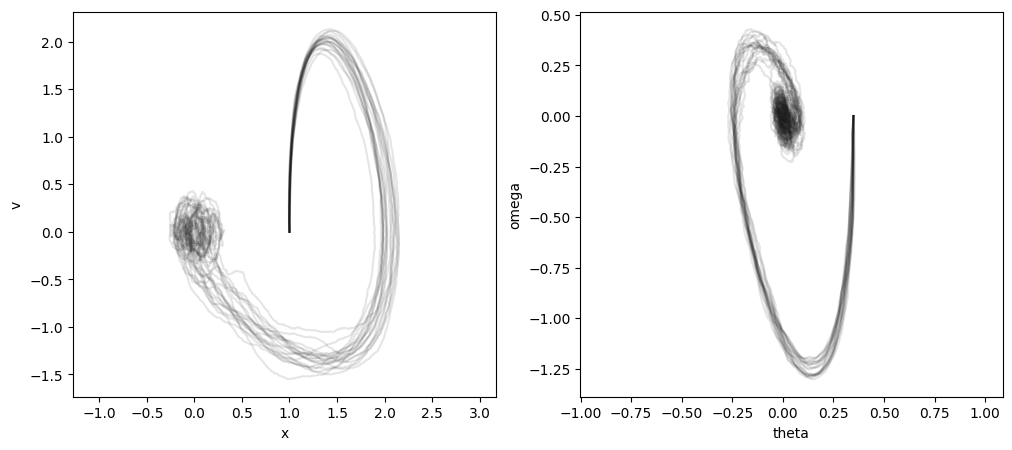

In [3]:
# 1.1 Solve the problem via LQG
LQG_strategy = lqg.solve(A, B, H, Q, R, Cx, Cu)
print(f"Expected performance: \nstate cost = {LQG_strategy['state_cost']:.2f}, action cost = {LQG_strategy['action_cost']:.2f}, bits = {LQG_strategy['bits']:.2f}")

# 1.2 Create environment, simulate, and visualize trajectories
env = sims.CartPole(m, M, l, g, d)
noise_cov = [Q, R]

N = 20
T = 10
horizon = int(T/dt)

init_s = np.array([1., 0., 20 * np.pi / 180, 0])
init_u = np.array([0])

s0, u0 = sims.nonlinear_sim(env, LQG_strategy, noise_cov, init_s, init_u, dt, horizon, N, lqg=True)
LQG_figures = viz.state_space_trajectories(s0, state_dimensions, 0, T, dt)

## 2. Frugal performance (optimal solution when information is costly)

In [4]:
# 2.0 Load an existing solution
frugal_params = np.load("../solutions/cart_pole.npy")
frugal_strategy = solver.readSol(A, B, H, Q, R, Cx, Cu, cn, params = frugal_params)
print(f"Expected performance: \nstate cost = {frugal_strategy['state']:.2f}, action cost = {frugal_strategy['action']:.2f}, inference cost = {frugal_strategy['info_cost']:.2f}")

Expected performance: 
state cost = 0.12, action cost = 2.41, inference cost = 5.46


In [ ]:
# 2.1 Compute solution from scratch

# Use LQG solution as initialization
LQG_strategy = lqg.solve(A, B, H, Q, R, Cx, Cu)
Psi = LQG_strategy['L'] @ LQG_strategy['K']
Pi = LQG_strategy['L'] @ LQG_strategy['G'] @ np.linalg.pinv(LQG_strategy['L'])

# Run solver
frugal_params, loss, success = solver.minimize(A, B, H, Q, R, Cx, Cu, cn, [Psi, Pi],
                                  learning_rate=.001, max_steps=200000, hess_step=1e-7)

# Read solution
frugal_strategy = solver.readSol(A, B, H, Q, R, Cx, Cu, cn, params = frugal_params)

In [11]:
# [Optional] Save solution
np.save("../solutions/cart_pole.npy", frugal_params)

# Compare Performance between unconstrained and frugal strategy
print(f"Expected performance (LQG): \nstate cost = {LQG_strategy['state_cost']:.2f}, action cost = {LQG_strategy['action_cost']:.2f}, bits = {LQG_strategy['bits']:.2f}")

print(f"Expected performance (frugal): \nstate cost = {frugal_strategy['state']:.2f}, action cost = {frugal_strategy['action']:.2f}, bits = {frugal_strategy['bits']:.2f}")

Expected performance (LQG): 
state cost = 0.16, action cost = 0.30, bits = 2.42
Expected performance (frugal): 
state cost = 0.11, action cost = 2.49, bits = 0.60


A 1-dimensional controller generates two solutions:


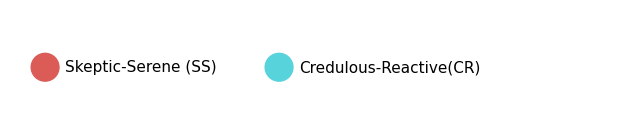

SS: Pi=[[0.87185061]], Psi=[[ 11.21826935  12.62611675 160.7257843   35.34238052]]
CR: Pi=[[-0.76142231]], Psi=[[ 55.40472232  50.52177858 993.51371712 118.2279694 ]]


In [12]:
# 2.2 Recover the complete solution family
family = solver.getFamily(A, B, H, Q, R, Cx, Cu, cn, frugal_strategy)
print("A 1-dimensional controller generates two solutions:")
viz.displaySpecialMembers([0, 1], ["Skeptic-Serene (SS)", "Credulous-Reactive(CR)"])
print(f"SS: Pi={family[0]['Pi']}, Psi={family[0]['Psi']}")
print(f"CR: Pi={family[1]['Pi']}, Psi={family[1]['Psi']}")


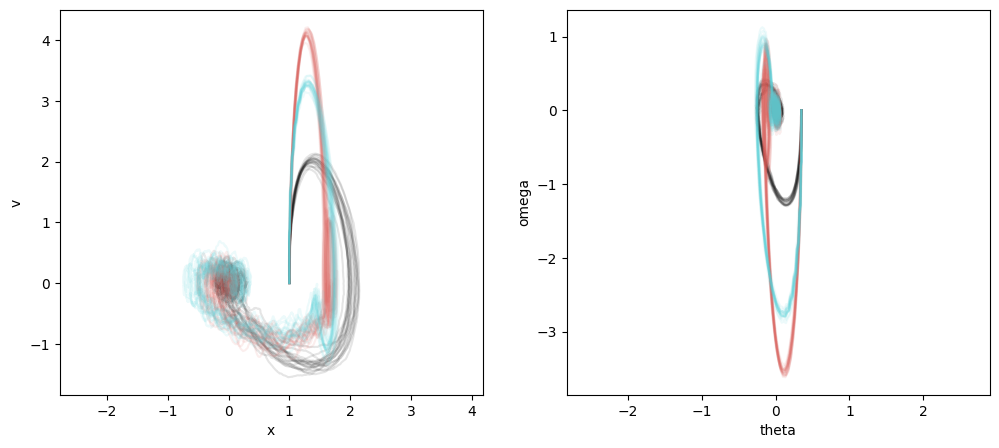

In [13]:
# 2.3 Run simulations and visualize trajectories, using the same simulation parameters declared for LQG control

s, u = [], []
start, stop = 0, T
figures = LQG_figures
for i, member in enumerate(family):
    states, actions = sims.nonlinear_sim(env, member, noise_cov, init_s, init_u, dt, horizon, N)
    s.append(states)
    u.append(actions)
    figures = viz.state_space_trajectories(states, state_dimensions, start, stop, dt, 'cart_pole', id_color=i, figures=figures)
# Display figure
figures[0]

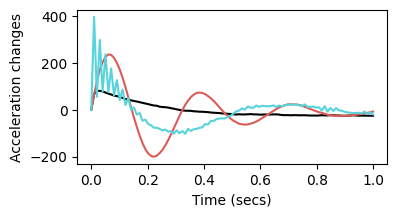

In [14]:
# 2.4 Visualize action trajectories (one trial)
start, stop = 0, 1
trial_id = 0
members_to_viz = [0, 1]

action_dim = 0   # Cart Pole actions are one dimensional
sample_trajectories = [u0[:, action_dim, trial_id], u[0][:, action_dim, trial_id], u[1][:, action_dim, trial_id]]
viz.action_trajectories(sample_trajectories, members_to_viz, 'cart_pole', start, stop, dt)

In [ ]:
# Compute animation and save it as a .gif
renderer = viz.CartPoleRenderer()
renderer.animate(s[0][:, :, 0], dt, save_path="../render_demos/cart_pole.gif", realtime=False)